In [ ]:
import requests
import pandas as pd
import numpy as np1
import datetime 
import math
import json

In [ ]:
def rising_curve(n):
    return (close60.iloc[-n] + close60.iloc[-1]) / 2 > close60.iloc[-int((n+1)/2)]

In [ ]:
def clean_df(df):
  DF = df.apply(lambda s:pd.to_numeric(s, errors='coerce'))
  DF = df[df.columns[df.isnull().all() == False]]
  return DF

In [ ]:
def crawl_fund(stockid):
  url = 'https://www.fugle.tw/api/v1/data/new_content/FCNT000005?symbol_id={}'.format(stockid)  
  data = json.loads(requests.get(url).text)
  date = data['rawContent'][0]['date']
  df = pd.DataFrame(data['rawContent'])  
  # df = clean_df(df)
  df['ITsell'] = pd.to_numeric(df['ITsell'])
  df['ITbuy'] = pd.to_numeric(df['ITbuy'])
  df['total'] = pd.to_numeric(df['total'])
  df['date'] = pd.to_datetime(df['date'])
  return df

In [ ]:
stockid = 3231
# stockid = 'TWSE_SEM_INDEX_1'
# stockid = 'TPEX_OTC_INDEX_1'
# beforeDay = 860
iniDate = '2010-01-01'
endDate = '2020-06-22'

In [ ]:
df = crawl_fund(stockid)

df['ITbuysell%'] =  (100 * (df['ITbuy'] - df['ITsell']) / df['total']).apply(lambda x:round(x,1))
# df = df[df['date'] > ((datetime.datetime.now() - datetime.timedelta(beforeDay)).strftime("%Y-%m-%d"))] 
df = df[(iniDate < df['date'])  & (df['date'] < endDate)] 
df = df.set_index('date')
# df
# df = df[[
        #  'ITbuy',
        #  'ITsell',
        #  'total',
        #  'ITbuysell%', 
        #  'ITbuysellsum', 
# ]]
df_IT = df.copy()
df_IT 

,FIbuy,FIsell,ITbuy,ITsell,DLbuy,DLsell,DLbuySelf,DLsellSelf,DLbuyHedge,DLsellHedge,total,DLbuyFi,DLsellFi,ITbuysell%
date,,,,,,,,,,,,,,
2016-01-03 16:00:00+00:00,2817320,3775000,0,0,233000,428000,12000,4000,221000,424000,-1152680,NaN,NaN,-0.0
2016-01-04 16:00:00+00:00,6076463,2675354,800000,780000,174000,460000,0,276000,174000,184000,3135109,NaN,NaN,0.6
2016-01-05 16:00:00+00:00,5709716,4772000,0,2354000,348000,1368000,0,12000,348000,1356000,-2436284,NaN,NaN,96.6
2016-01-06 16:00:00+00:00,11786502,4036900,0,0,997000,848000,1000,0,996000,848000,7898602,NaN,NaN,0.0
2016-01-07 16:00:00+00:00,6061383,8940067,400000,0,714000,179000,2000,10000,712000,169000,-1943684,NaN,NaN,-20.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-15 16:00:00+00:00,4703609,3007000,2159000,0,193000,169000,140000,0,53000,169000,3879609,0.0,0.0,55.6
2020-06-16 16:00:00+00:00,9394082,4179607,4517000,0,605000,516000,251000,375000,354000,141000,9820475,0.0,0.0,46.0
2020-06-17 16:00:00+00:00,23906868,11118902,2015000,2000,734000,573000,233000,38000,501000,535000,14961966,0.0,0.0,13.5


In [ ]:
def crawl_price(stockid):
  url = 'https://www.fugle.tw/api/v1/data/new_content/FCNT000099?symbol_id={}'.format(stockid)
  r = requests.get(url)  
  data = json.loads(r.text)
  df = pd.DataFrame(data['rawContent']['day'])
  # df = clean_df(df)  
  return df

In [ ]:
df= crawl_price(stockid)
df['date'] = pd.to_datetime(df['date'])
df['volumeOrAmount'] = pd.to_numeric(df['volumeOrAmount'])

# df = df[df['date'] > ((datetime.datetime.now() - datetime.timedelta(beforeDay)).strftime("%Y-%m-%d"))] 
df = df[(iniDate < df['date'])  & (df['date'] < endDate)] 
df = df.set_index('date')

df_stock = df.copy()

# df = df[['open','high','low','close']]
# df.columns = ['Open', 'High', 'Low', 'Close']

df = df[[
        #  'volumeOrAmount',
         'open','high','low', 'close'
]]

df.columns = [
              # 'Volume',
              'Open', 'High', 'Low', 'Close'
]
# df = df.apply(lambda s:pd.to_numeric(s, errors='coerce'))
# df = df[df.columns[df.isnull().all() == False]]

# df_stock
df

# df_close.plot()
# df_ITbuy['avg'].plot()
# df_ITsell['avg'].plot(color='red')


,Open,High,Low,Close
date,,,,
2015-01-04 16:00:00+00:00,28.40,29.05,28.40,28.75
2015-01-05 16:00:00+00:00,28.50,28.55,28.00,28.10
2015-01-06 16:00:00+00:00,28.10,28.45,28.00,28.30
2015-01-07 16:00:00+00:00,28.40,29.10,28.40,28.95
2015-01-08 16:00:00+00:00,29.40,29.50,29.10,29.10
...,...,...,...,...
2020-06-15 16:00:00+00:00,31.50,31.50,31.15,31.45
2020-06-16 16:00:00+00:00,31.55,32.30,31.50,32.25
2020-06-17 16:00:00+00:00,32.40,34.30,32.35,34.00


In [ ]:
# !pip install backtesting
# !pip install backtrader

In [ ]:
from backtesting import Backtest
from backtesting.lib import SignalStrategy
import pandas as pd
from backtesting.test import SMA, GOOG

In [ ]:
class Strategy(SignalStrategy):
    
    n1 = 5
    n2 = 20
    m1 = 5

    # m2 = 5
    def init(self):
        super().init()
        # Precompute the two moving averages
        close =  pd.Series(self.data.Close)
        self._n1 = self.I(SMA, close, self.n1)
        self._n2 = self.I(SMA, close, self.n2)
        
        
        sma1 = close.rolling(self.n1).mean()
        sma2 = close.rolling(self.n2).mean()
        
        

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        
        # ITbuy = df_IT['ITbuy'] * df['Close'].rolling(self.m1, min_periods=1).sum() / df_IT['ITbuy'].rolling(self.m1, min_periods=1).sum()
        # df_ITsell = df_IT['ITsell'] * df['Close'].rolling(self.m2, min_periods=1).sum() / df_IT['ITsell'].rolling(self.m2, min_periods=1).sum()        
        # df_ITbuy = (df_IT['ITbuy'] - df_IT['ITsell']) == ((df_IT['ITbuy'].rolling(20, min_periods=1).sum() - df_IT['ITsell']).rolling(20, min_periods=1).sum())

        
        # ITbuy = (df_IT['ITbuy'] - df_IT['ITsell']) / (df_stock['volumeOrAmount'] *1000) *100
        # ITsell = (df_IT['ITbuy'] - df_IT['ITsell']) / (df_stock['volumeOrAmount'] *1000) *100        
        ITbuy = (df_IT['ITbuy']) / (df_stock['volumeOrAmount'] *1000) *100
        ITsell = (df_IT['ITsell']) / (df_stock['volumeOrAmount'] *1000) *100
        
        # print(df_stock['volumeOrAmount']*1000)
        # print(df_IT['ITbuy'])
        # print(ITbuy )
        
        ITbuy_long = ITbuy > self.m1
        ITsell_short = ITsell > self.m1
        
        df.reset_index(inplace=True, drop=True)
        ITbuy_long.reset_index(inplace=True, drop=True)
        ITsell_short.reset_index(inplace=True, drop=True)
       

        # IT_avg_long = (df['Close'] < df_ITbuy) & (df['Close'].shift() > df_ITbuy.shift())
        # IT_avg_short = (df['Close'] > df_ITbuy) & (df['Close'].shift() < df_ITbuy.shift())        
        # IT_avg_long.reset_index(inplace=True, drop=True)
        # IT_avg_short.reset_index(inplace=True, drop=True)
  
       
        # IT_buymore_long = df_ITbuy > df_ITsell 
        # IT_buymore_short = df_ITbuy < df_ITsell        
        # IT_buymore_long.reset_index(inplace=True, drop=True)
        # IT_buymore_short.reset_index(inplace=True, drop=True)


        # signal_long = IT_buymore_long & signal_long
        # signal_short = IT_buymore_short & signal_short
        
        signal_long = ITbuy_long  
        # signal_short = ITsell_short

        # signal_long = ITbuy_long  & signal_long

        signal_short = ITsell_short & signal_short

        # print(signal_long)
        # print(signal_short)

       
        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # add signal
        self.set_signal(signal)
bt = Backtest(df, Strategy)
result1 = bt.run()
# print(result1)
bt.plot()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.


In [ ]:
print(result1)

Start                     2015-01-04 16:00:00+00:00
End                       2020-06-21 16:00:00+00:00
Duration                         1995 days 00:00:00
Exposure [%]                                81.6541
Equity Final [$]                            12574.5
Equity Peak [$]                             14715.4
Return [%]                                  25.7453
Buy & Hold Return [%]                       21.0435
Max. Drawdown [%]                          -58.2566
Avg. Drawdown [%]                           -8.6766
Max. Drawdown Duration           1252 days 00:00:00
Avg. Drawdown Duration            108 days 00:00:00
# Trades                                         58
Win Rate [%]                                67.2414
Best Trade [%]                              19.4842
Worst Trade [%]                             -20.155
Avg. Trade [%]                             0.609537
Max. Trade Duration               191 days 00:00:00
Avg. Trade Duration                29 days 00:00:00
Expectancy [

In [ ]:
result2 = bt.optimize(
                      # n1=range(5, 100, 5),
                      # n2=range(5, 100, 5),
                      m1=range(1, 1000, 5),
)
bt.plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  


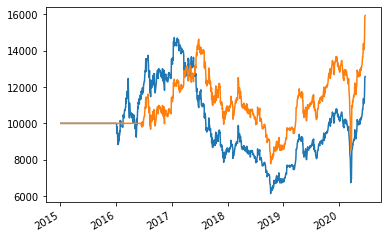

In [ ]:
result1._trade_data.Equity.plot()
result2._trade_data.Equity.plot()

In [ ]:
print(result2.loc['_strategy'])

Strategy(m1=11)
